In [1]:
import numpy as np
import pandas as pd
import missingno as msno

In [2]:
data = pd.read_csv("mushrooms.csv")
data.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,convex,smooth,brown,True,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
1,True,convex,smooth,yellow,True,almond,free,close,broad,black,...,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses
2,True,bell,smooth,white,True,anise,free,close,broad,brown,...,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows
3,False,convex,scaly,white,True,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
4,True,convex,smooth,gray,False,none,free,crowded,broad,black,...,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses


<Axes: >

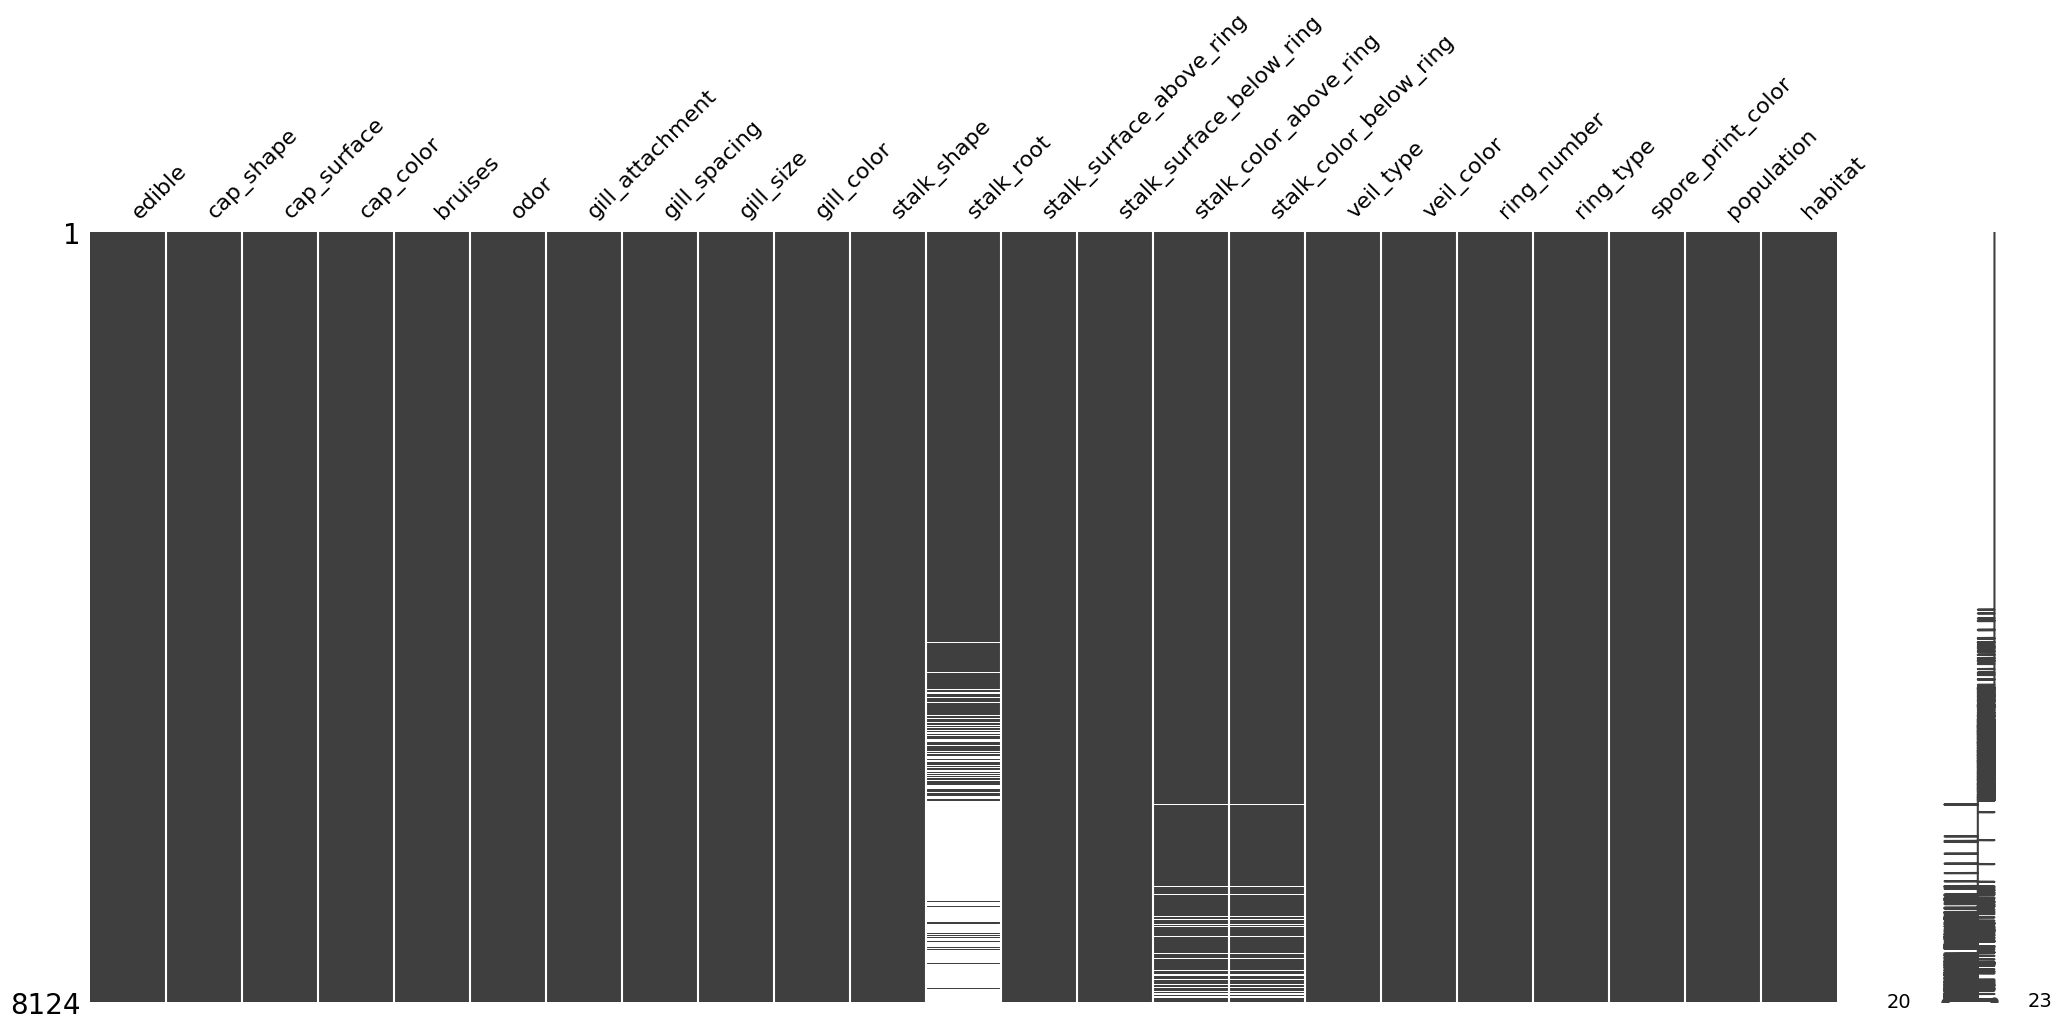

In [3]:
msno.matrix(data)

In [4]:
data.drop(columns=["veil_type"], inplace=True)

## Feature Selection --> threshold 0.60

In [5]:
!pip install dython

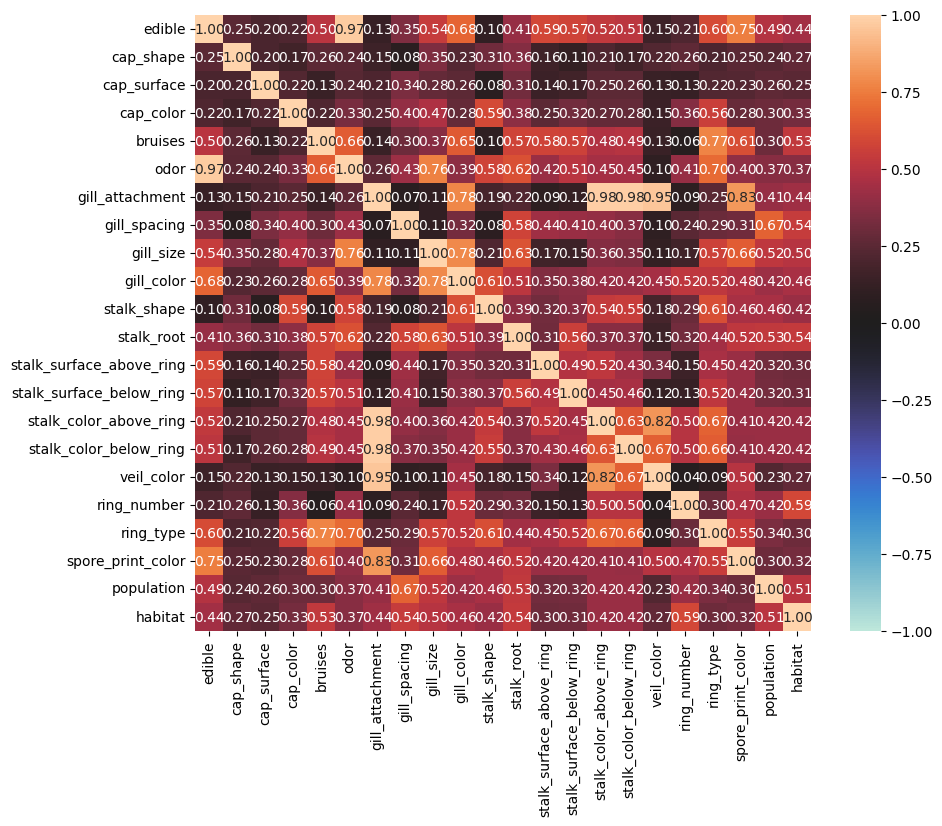

In [6]:
from dython.nominal import associations
import matplotlib.pyplot as plt

association_matrix = associations(data, nom_nom_assoc='cramer', figsize=(10, 8))

plt.show()

## Splitting

In [11]:
from sklearn.model_selection import train_test_split

X = data[["odor","gill_color","ring_type","spore_print_color"]]
y = data["edible"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6499, 4), (1625, 4), (6499,), (1625,))

## Training

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), X_train.columns)
    ]
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

parameter = {
    'algo__fit_intercept': [True, False],
    'algo__solver': ['lbfgs', 'liblinear']
}

In [13]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['odor', 'gill_color', 'ring_type', 'spore_print_color'], dtype='object'))])),
                                       ('algo', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'algo__fit_intercept': [True, False],
                         'algo__solver': ['lbfgs', 'liblinear']},
             verbose=1)

In [14]:
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__fit_intercept': True, 'algo__solver': 'lbfgs'}
0.9932297276504077 0.9932298930358466 0.9975384615384615


## Evaluasi Model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

Jumlah data train: 6499
Jumlah data test: 1625

**Evaluasi pada Data Train**
Akurasi: 0.9932
Precision: 0.9933
Recall: 0.9932
F1-Score: 0.9932

**Evaluasi pada Data Test**
Akurasi: 0.9975
Precision: 0.9976
Recall: 0.9975
F1-Score: 0.9975


In [16]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      3133
        True       0.99      1.00      0.99      3366

    accuracy                           0.99      6499
   macro avg       0.99      0.99      0.99      6499
weighted avg       0.99      0.99      0.99      6499


Classification Report - Test Data:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       783
        True       1.00      1.00      1.00       842

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



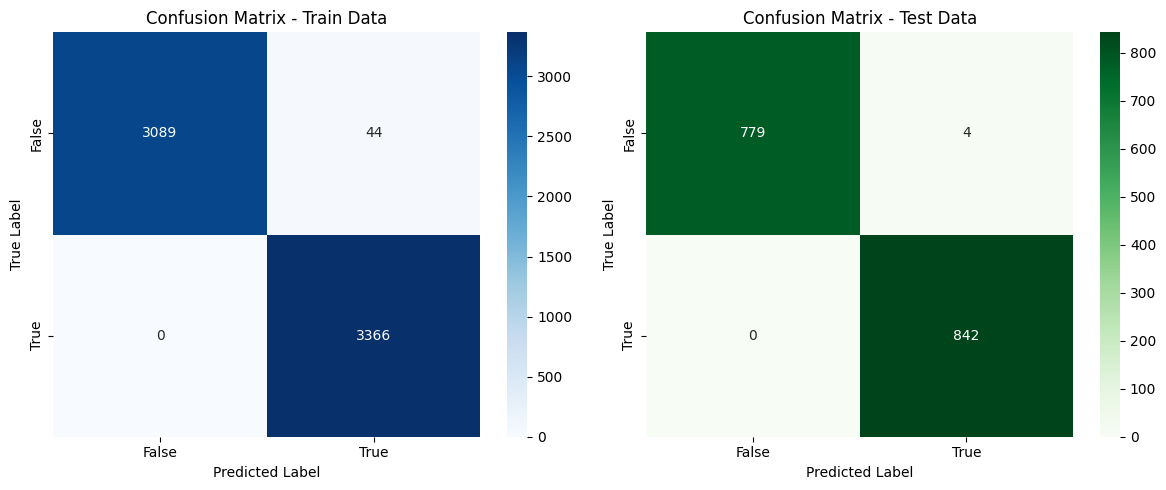

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [28]:
y_train.value_counts()

,count
edible,
True,3366
False,3133


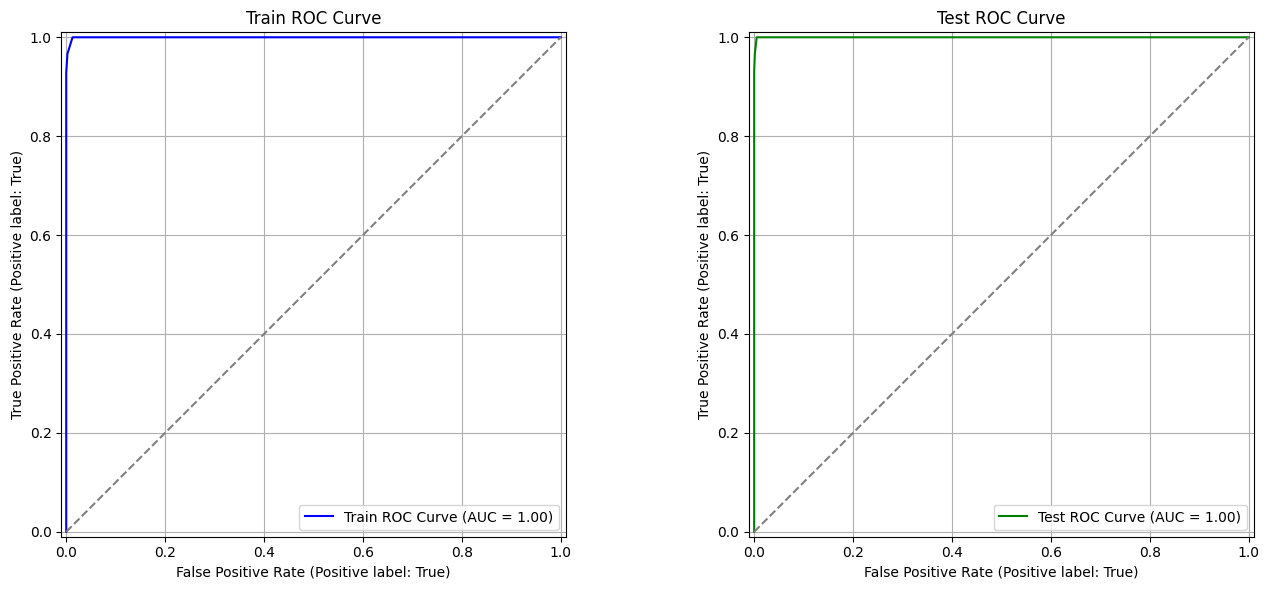

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

RocCurveDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train ROC Curve", color="blue"
)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title("Train ROC Curve")
axes[0].grid()

RocCurveDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test ROC Curve", color="green"
)
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("Test ROC Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

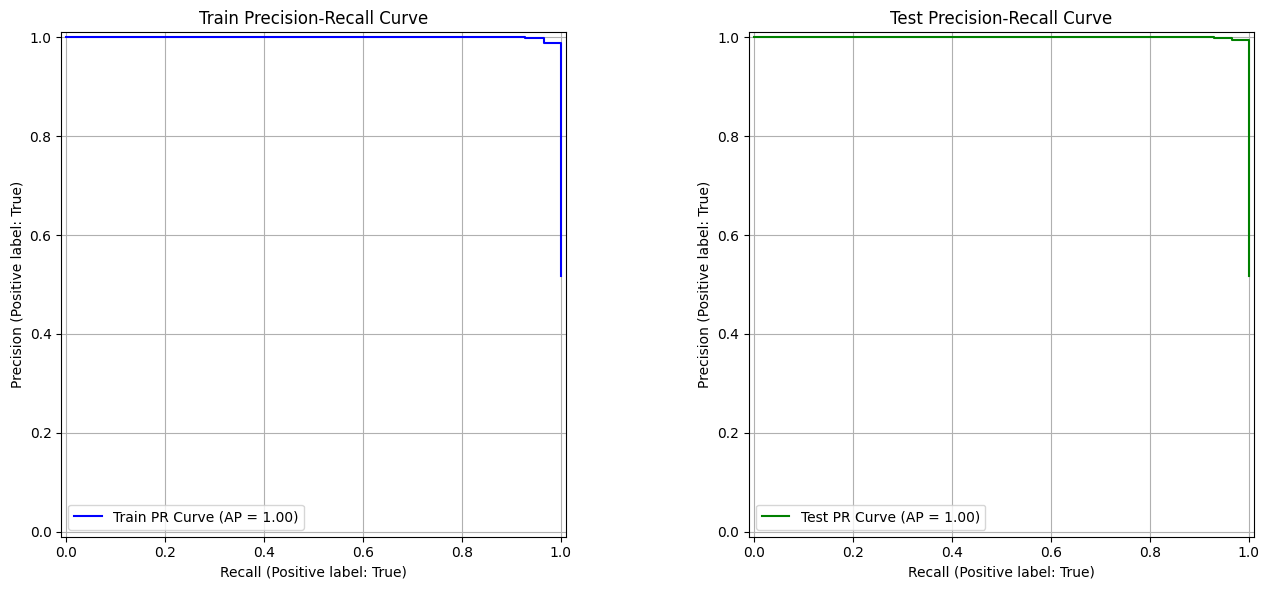

In [37]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train PR Curve", color="blue"
)
axes[0].set_title("Train Precision-Recall Curve")
axes[0].grid()

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test PR Curve", color="green"
)
axes[1].set_title("Test Precision-Recall Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

## Feature Importance

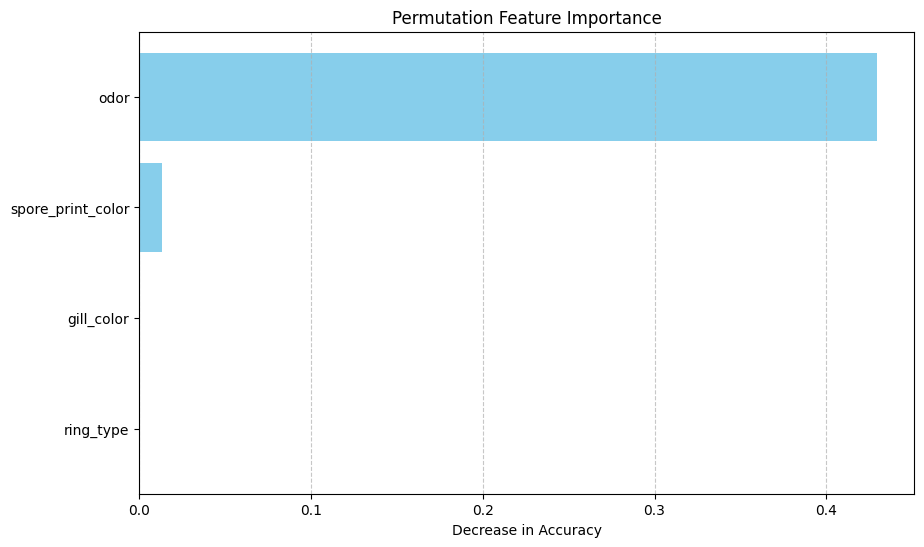

In [38]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.title('Permutation Feature Importance')
plt.xlabel('Decrease in Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Save Model

In [39]:
import pickle

best_pipeline = model.best_estimator_
with open("mushroom.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)

## Load Model

In [40]:
import pickle

with open("mushroom.pkl", "rb") as file:
    loaded_model = pickle.load(file)

## Prediksi

In [42]:
X_train.iloc[1]

,6451
odor,fishy
gill_color,buff
ring_type,evanescent
spore_print_color,white


In [43]:
new_data = pd.DataFrame({
    'odor': ['fishy', 'pungent', 'anise'],
    'gill_color': ['buff', 'brown', 'black'],
    'ring_type': ['evanescent', 'pendant', 'pendant'],
    'spore_print_color': ['white', 'brown', 'black']
})

new_data['Predict'] = loaded_model.predict(new_data)
new_data

,odor,gill_color,ring_type,spore_print_color,Predict
0,fishy,buff,evanescent,white,False
1,pungent,brown,pendant,brown,False
2,anise,black,pendant,black,True
